In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 1

import numpy as np
import matplotlib
matplotlib.rcParams['figure.dpi'] = 90

import matplotlib.pyplot as plt

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png','pdf')

%aimport detectors

/Users/drsmith/opt/miniconda3/lib/python3.9/site-packages/numpy/core/function_base.py:277: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


# Diodes and noise

Photodiodes convert incident radiant flux $P_{inc}$ into a photocurrent $I_{ph}$:

$$I_{ph} = G\cdot R\cdot P_{inc}\quad[A]$$

where $G$ is diode gain, $R$ is diode responsivity in $A/W$ and $P_{inc}$ is the indicdent radiant flux in $W$.  The diode responsivity $R$ is related to the diode quantum efficiency $QE$:

$$R = QE\cdot\frac{\lambda[nm]}{1240}\quad[A/W]$$

PIN diodes have gain $G=1$, and APDs have $G>1$ (typ. 50-100).

Photodiodes are susceptible to shot noise and thermal noise, and APDs additionally are susceptible to "excess noise".  The excess noise is characterized by the excess noise factor $F\ge 1$.  APDs have $F>1$, and to unify notation, PIN diodes conceptualy have $F=1$.  PIN diode and APD noise sources:
- Shot noise from photocurrent and dark (leakage) current
  - APDs have volume dark current that is subject to gain and excess noise and surface dark current that is not subject to gain and excess noise
  - Shot noise from the photocurrent is the irreducible minimum noise, and it is often known as the "photon noise limit"
- Thermal (Johnson) noise from diode shunt resistance
  - Negligible for APDs; likely negligible for PIN diodes
- APD only: Excess noise factor
  - A multiplicitive factor on shot noise terms

All of the above noise sources are white noise with a flat frequency spectrum.  (As discussed below, the diode junction capacitance contributes to the "ENC" or channel noise in the JFET and TIA.)  Noise sources are expressed in terms of current noise power density (CNPD), denoted by $i^2$ with units $A^2/Hz$.  When expressed as a power density, noise sources are additive:

$$i^2_{total} = i^2_1 + i^2_2 + i^2_3\cdots$$

Noise current $i^2$ may be frequency independent (flat, white noise) or frequency dependent.  Shot noise and thermal noise are flat, but "ENC" noise discussed below is frequency dependent.  For flat noise sources, the RMS noise current is

$$I_{noise,rms}=\sqrt{i^2_{total} * B}\quad[A]$$

where $B$ is the bandwidth in $Hz$.  More generally, for frequency dependent noise sources, the RMS noise current is

$$I_{noise,rms}=\sqrt{\int i^2_{total}(\omega)\,d\omega}\quad[A]$$

The *instantaineous* signal-to-noise ratio $SNR$ is

$$SNR = \frac{I_{ph}}{I_{noise,rms}}$$

The frequency-resolved noise floor is lower than indicated by the instantaineous $SNR$ due to time averaged statistics.

In [2]:
diodes = {
    'API_C164_PIN' : detectors.PinDiode(
        name='AP PDB-C164 disc. PIN',
        responsivity=0.43,  # A/W @ 650 nm
        darkcurrent_ref=1e-9,  # typ 1 nA, max 10 nA @ T=20C
        junction_cap_ref=7e-12,  # typ 7 pF @ Vr=10V
        vb_ref=10,  # reference bias voltage for junction cap.
        r_shunt=500e6,  # shunt resistance
    ),
    'Hama_S13620_PIN' : detectors.PinDiode(
        name='Hama. S13620 8x8 PIN',
        responsivity=0.49,  # A/W @ 650 nm
        darkcurrent_ref=0.3e-9,  # typ 10 pA, max 300 pA @ Vr=10mV, T=20C
        junction_cap_ref=15e-12,  # typ 15 pF @ Vr=8.6V
        vb_ref=8.6,
    ),
    'Hama_S8550_APD_2' : detectors.ApdDiode(
        name='Hama. S8550 4x8 APD',
        qe=0.85,  # QE @ 650 nm
        gain=50,  # gain @ Vr=330 V
        darkcurrent_ref=1e-9,  # typ 1 nA, max 10 nA @ Vr=330V, M=50
        junction_cap_ref=9e-12,  # typ 9 pF @ Vr=330V, M=50
        noise_index=0.2,
        vb_ref=330,  # reference bias for gain and junction cap.
    ),
}

AP PDB-C164 disc. PIN
  QE = 81.3 %
  Resp. = 0.43 A/W
  Dark current (total or vol.) = 1.0 nA
  Junction cap = 7.0 pF
  Shunt res. = 500 MOhms
Hama. S13620 8x8 PIN
  QE = 92.6 %
  Resp. = 0.49 A/W
  Dark current (total or vol.) = 0.3 nA
  Junction cap = 15.0 pF
  Shunt res. = 250 MOhms
Hama. S8550 4x8 APD
  QE = 85.0 %
  Resp. = 0.45 A/W
  Dark current (total or vol.) = 1.0 nA
  Junction cap = 9.0 pF
  Shunt res. = 250 MOhms
  Gain = 50
  Noise index = 0.2
  Noise factor = 2.187


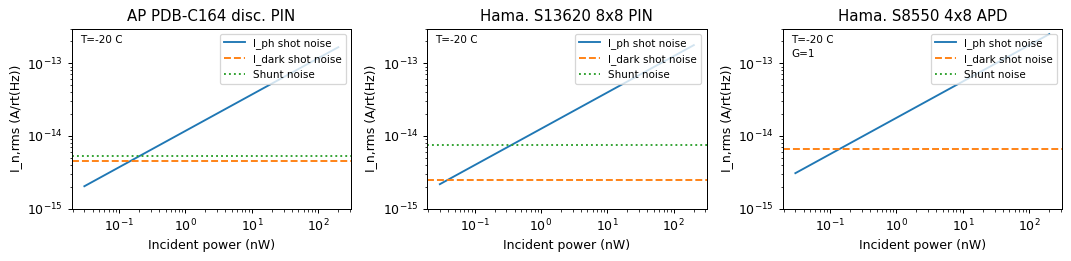

In [3]:
ncols, nrows = 3, 1
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))

p_inc = np.geomspace(0.03,200)  # incident power [nW]
temp = -20

iplot=0
for diode in diodes.values():
    plt.sca(axes.flat[iplot])
    plt.title(diode.name)
    plt.loglog(p_inc, 
        np.sqrt(diode.photocurrent_shot_noise_CNPD(p_inc) / diode.gain**2),
        label='I_ph shot noise', c='C0')
    plt.axhline(
        np.sqrt(diode.dark_current_shot_noise_CNPD(t=temp) / diode.gain**2),
        label='I_dark shot noise', ls='--', c='C1')
    plt.axhline(
        np.sqrt(diode.shunt_noise_CNPD(t=temp) / diode.gain**2),
        label='Shunt noise', ls=':', c='C2')
    plt.xlabel('Incident power (nW)')
    plt.ylabel('I_n,rms (A/rt(Hz))')
    plt.ylim(1e-15,3e-13)
    plt.legend(fontsize='small', loc='upper right')
    plt.annotate(f'T={temp:.0f} C', (0.03,0.92), xycoords='axes fraction', fontsize='small')
    if isinstance(diode, detectors.ApdDiode):
        plt.annotate('G=1', (0.03,0.84), xycoords='axes fraction', fontsize='small')
    iplot += 1

plt.tight_layout()

# Diode comparison (no TIA)

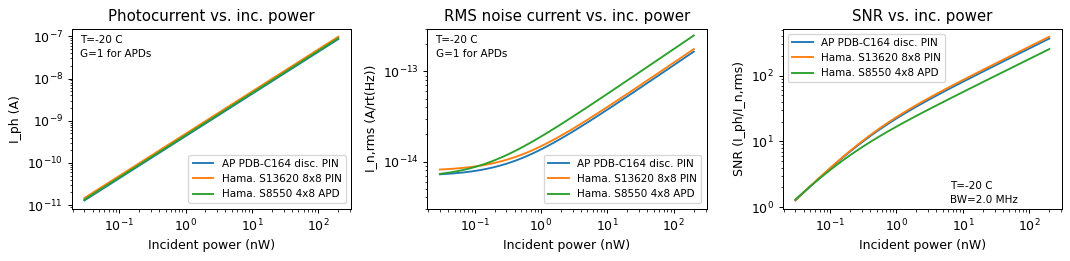

In [4]:
ncols, nrows = 3,1
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))

iplot = 0

# photocurrent vs. inc. power
plt.sca(axes.flat[iplot])
plt.title('Photocurrent vs. inc. power')
for diode in diodes.values():
    plt.loglog(p_inc, 
        diode.photocurrent(p_inc)/diode.gain,
        label=diode.name)
plt.xlabel('Incident power (nW)')
plt.ylabel('I_ph (A)')
plt.legend(fontsize='small', loc='lower right')
plt.annotate(f'T={temp:.0f} C', (0.03,0.92), xycoords='axes fraction', fontsize='small')
plt.annotate('G=1 for APDs', (0.03,0.84), xycoords='axes fraction', fontsize='small')
iplot +=1

# noise vs. inc. power
plt.sca(axes.flat[iplot])
plt.title('RMS noise current vs. inc. power')
for diode in diodes.values():
    noise_CNPD = diode.photocurrent_shot_noise_CNPD(p_inc) + \
        diode.dark_current_shot_noise_CNPD(t=temp) + \
        diode.shunt_noise_CNPD(t=temp)
    plt.loglog(p_inc,
        np.sqrt(noise_CNPD / diode.gain**2),
        label=diode.name)
plt.xlabel('Incident power (nW)')
plt.ylabel('I_n,rms (A/rt(Hz))')
plt.ylim(3e-15,3e-13)
plt.legend(fontsize='small', loc='lower right')
plt.annotate(f'T={temp:.0f} C', (0.03,0.92), xycoords='axes fraction', fontsize='small')
plt.annotate('G=1 for APDs', (0.03,0.84), xycoords='axes fraction', fontsize='small')
iplot+=1

# SNR vs. inc. power
plt.sca(axes.flat[iplot])
bw=2e6
plt.title(f'SNR vs. inc. power')
for diode in diodes.values():
    photocurrent = diode.photocurrent(p_inc)
    noise_current = np.sqrt(bw*(diode.photocurrent_shot_noise_CNPD(p_inc) + \
        diode.dark_current_shot_noise_CNPD(t=temp) + \
        diode.shunt_noise_CNPD(t=temp)))
    plt.loglog(p_inc,
        photocurrent/noise_current,
        label=diode.name)
plt.xlabel('Incident power (nW)')
plt.ylabel('SNR (I_ph/I_n,rms)')
plt.annotate(f'T={temp:.0f} C', (0.6,0.11), xycoords='axes fraction', fontsize='small')
plt.annotate(f'BW={bw/1e6:.1f} MHz', (0.6,0.03), xycoords='axes fraction', fontsize='small')
plt.legend(fontsize='small',
    loc='upper left')
iplot+=1

plt.tight_layout()

# Diode discussion

Typical APDs have excess noise figure $NF\sim2$ and excess noise factor $F\sim1.5$.  They are related by:

$$F=10^{NF/10}$$

The APD excess noise increases shot noise and decreases the effective quantum efficiency.  The higher noise and lower SNR of the APD is evident at high incident powers, $\gtrsim$ 1 nW.  At low incident power and low shot noise, the APD gives lower noise and higher SNR relative to the PIN diode because the shunt noise is effectively reduced by the gain.

The Hamamatsu S8550 4x8 APD array has **exceptionally** low excess noise with $NF=0.2$ and $F=1.05$.  The low excess noise leads to lower noise and higher SNR for the Hamamatsu S8550 APD up to ~ 1000 nW, above which the PIN diode has lower noise and higher SNR.

# Transimpedance amplifier (TIA)

TIA current noise sources

- Shot noise from FET gate current
- Thermal (Johnson) noise from feedback resistor
- Current noise from TIA voltage noise and input capacitance
  - Input capacitance includes diode junction cap., FET cap., and board stray cap.

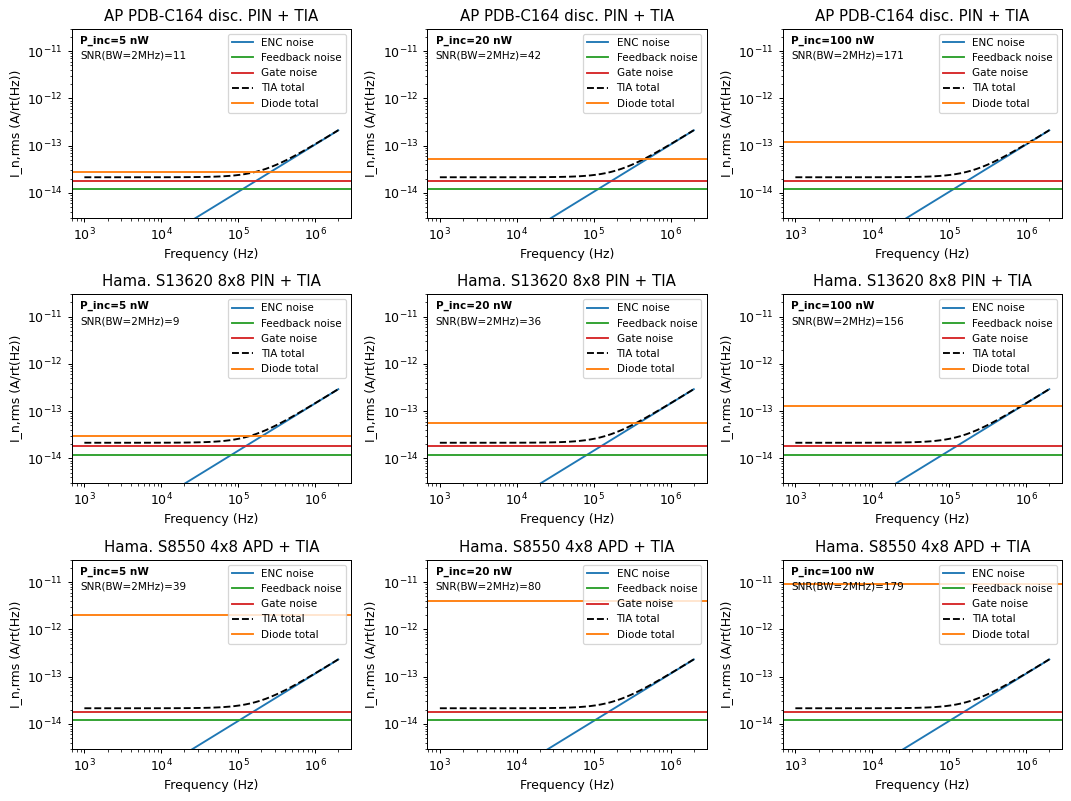

In [5]:
tia = detectors.TIA()

ncols, nrows = 3, len(diodes)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))

# p_inc = np.geomspace(0.1,200)  # incident power [nW]
temp = -20
bw = 2e6
f_ref = np.geomspace(1e3, bw)
f_diff = np.diff(f_ref, prepend=0)
# print(f_diff[0], f_diff[-1])

iplot=0

for diode in diodes.values():
    for p_inc in [5,20,100]:
        plt.sca(axes.flat[iplot])
        plt.title(f'{diode.name} + TIA')
        I_photo = diode.photocurrent(p_inc=p_inc)
        diode_CNPD = (diode.photocurrent_shot_noise_CNPD(p_inc) + \
            diode.dark_current_shot_noise_CNPD(t=temp) + \
            diode.shunt_noise_CNPD(t=temp))  # nA^2/Hz
        feedback_noise_CNPD = tia.feedback_noise_CNPD(t=temp)  # nA^2/Hz
        gate_noise_CNPD = tia.gate_noise_CNPD()
        diode_junction_cap = diode.junction_cap()
        enc_noise_CNPD = tia.enc_noise_CNPD(f=f_ref, diode_junction_cap=diode_junction_cap)
        TIA_noise_NCPD = enc_noise_CNPD + gate_noise_CNPD + feedback_noise_CNPD
        total_noise = TIA_noise_NCPD + diode_CNPD
        int_noise = np.sqrt(np.sum(total_noise * f_diff))  # I_n,rms
        SNR = I_photo / int_noise
        plt.loglog(f_ref, np.sqrt(enc_noise_CNPD), label='ENC noise', c='C0')
        plt.axhline(np.sqrt(feedback_noise_CNPD), label='Feedback noise', c='C2')
        plt.axhline(np.sqrt(gate_noise_CNPD), label='Gate noise', c='C3')
        plt.loglog(f_ref, np.sqrt(TIA_noise_NCPD), label='TIA total', c='k', ls='--')
        plt.axhline(np.sqrt(diode_CNPD), label='Diode total', c='C1')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('I_n,rms (A/rt(Hz))')
        plt.ylim(3e-15,3e-11)
        plt.annotate(f'P_inc={p_inc:.0f} nW',
            xycoords='axes fraction',
            xy=[0.03,0.92],
            fontsize='small',
            fontweight='bold')
        plt.annotate(f'SNR(BW={bw/1e6:.0f}MHz)={SNR:.0f}',
            xycoords='axes fraction',
            xy=[0.03,0.84],
            fontsize='small')
        plt.legend(loc='upper right', fontsize='small')
        iplot += 1


plt.tight_layout()

# Diode+TIA SNR vs. incident power and bandwidth

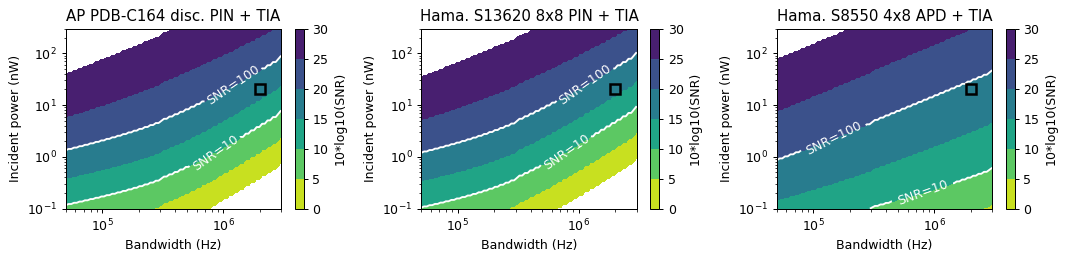

In [6]:
ncols, nrows = 3, 1
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))


np_inc, nbw = 80, 80

p_inc_array = np.geomspace(1e-1,3e2,np_inc)
f_max=3e6
f_ref = np.geomspace(1e3,f_max,80)
f_diff = np.diff(f_ref, prepend=0)
bw_ref_array = np.geomspace(50e3,f_max,nbw)

iplot=0
for diode in diodes.values():
    plt.sca(axes.flat[iplot])
    plt.title(f'{diode.name} + TIA')
    SNR = np.zeros((np_inc, nbw))
    for ip, p_inc in enumerate(p_inc_array):
        I_photo = diode.photocurrent(p_inc=p_inc)
        diode_CNPD = (diode.photocurrent_shot_noise_CNPD(p_inc) + \
            diode.dark_current_shot_noise_CNPD(t=temp) + \
            diode.shunt_noise_CNPD(t=temp))  # nA^2/Hz
        feedback_noise_CNPD = tia.feedback_noise_CNPD(t=temp)  # nA^2/Hz
        gate_noise_CNPD = tia.gate_noise_CNPD()
        diode_junction_cap = diode.junction_cap()
        enc_noise_CNPD = tia.enc_noise_CNPD(f=f_ref, diode_junction_cap=diode_junction_cap)
        TIA_noise_NCPD = enc_noise_CNPD + gate_noise_CNPD + feedback_noise_CNPD
        total_noise = TIA_noise_NCPD + diode_CNPD
        noise_times_bw = total_noise * f_diff
        for ibw, bw_ref in enumerate(bw_ref_array):
            int_noise = np.sqrt(np.sum(noise_times_bw[f_ref<=bw_ref]))  # I_n,rms
            SNR[ip, ibw] = I_photo / int_noise
    plt.contourf(bw_ref_array, p_inc_array, 
        10*np.log10(SNR),
        levels=np.linspace(0,30,7),
        cmap='viridis_r'
        )
    plt.xscale('log')
    plt.xlabel('Bandwidth (Hz)')
    plt.yscale('log')
    plt.ylabel('Incident power (nW)')
    plt.clim(0,30)
    cb = plt.colorbar()
    cb.set_label('10*log10(SNR)')
    clines = plt.contour(bw_ref_array, p_inc_array, 
        10*np.log10(SNR),
        levels=[10,20], colors='w')
    plt.clabel(clines, colors='w', fmt={10:'SNR=10', 20:'SNR=100'})
    plt.plot(2e6,20, 'sk', ms=8, mew=2, fillstyle='none')
    iplot += 1

plt.tight_layout()